<a target="_blank" href="https://colab.research.google.com/github/wbfrench1/barker_DATA606/blob/main/src/crf_models/Sarkar_Custom_Movie_NER_Model.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# Ran into the following error: AttributeError: 'CRF' object has no attribute 'keep_tempfiles'
# Used below resolution
#https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60
!pip install -U 'scikit-learn<0.24'
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 26.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-0.23.2-cp39-cp39-linux_x86_64.whl size=24678623 sha256=2f3b2add41728b775573274bc0de3499447ce67af0cf05ebebd35ae13b85e890
  Stored in directory: /root/.cache/pip/wheels/5e/74/24/7e235ccf01765c0daa089c98cc823e9dc1383da5fe0ed7e224
Successfully built scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requi

In [2]:
from google.colab import drive
import requests
import pandas as pd
import random
import numpy as np
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
import joblib
from sklearn_crfsuite import metrics as crf_metrics
import nltk
nltk.download('averaged_perceptron_tagger')
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import pickle

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# 1. Read in the Data

##   1.a. Read in the Sarkar data
##   1.b. Read in the movie data


In [3]:
df_ex = pd.read_csv('https://github.com/wbfrench1/barker_DATA606/blob/05c1c56275fcaf7e4df300b578f65f62127dad18/data/ner_dataset.csv.gz?raw=true',
                    encoding='latin1',compression='gzip')
df = pd.read_csv('https://github.com/wbfrench1/barker_DATA606/blob/05c1c56275fcaf7e4df300b578f65f62127dad18/data/movie_data.csv?raw=true')

In [4]:
# bring the Sentence label forward to each word in the sentence
df_ex['Sentence #'].ffill(inplace=True)

# 2. Explore the Data

In [5]:
df_ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048575 non-null  object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [6]:
df_ex['Sentence #'].nunique(), df_ex['Word'].nunique(), df_ex['POS'].nunique(), df_ex['Tag'].nunique()

(47959, 35178, 42, 17)

In [7]:
df_ex.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [8]:
df_ex.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [9]:
# Differentiate the question columns.  q_num is absoloute, while
## q_num_by_src is a numbering for each of the four, movie data
### sets
df.rename(columns={'quest_num':'q_num_by_src',
                   'label': 'postag',
                   'entity' : 'tag'}, inplace=True)

In [10]:
df.head()

,q_num_by_src,postag,word,pos,tag,source,q_num
0,1,o-outside,what,o,outside,eng_train,1
1,1,o-outside,movies,o,outside,eng_train,1
2,1,o-outside,star,o,outside,eng_train,1
3,1,b-actor,bruce,b,actor,eng_train,1
4,1,i-actor,willis,i,actor,eng_train,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322035 entries, 0 to 322034
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   q_num_by_src  322035 non-null  int64 
 1   postag        322035 non-null  object
 2   word          322034 non-null  object
 3   pos           322035 non-null  object
 4   tag           322035 non-null  object
 5   source        322035 non-null  object
 6   q_num         322035 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 17.2+ MB


# 3. Create features in the data

In [12]:
def word2features(l_sent: list, i) -> dict:

    '''   Description:  Takes a list of sentence tuples and an integer 
                        identifying the word the function will work on and
                        returns a dictionary containing the words in
                        each sentence and corresponding features.
                        
                        l_sents: is formatted as a list of tuples where each 
                                 tuple is a:
                                   word in the sentence, 
                                   a part of speech tag,
                                   and an NER tag

                                   (word:str, POS:str, NER:str)
        
          Returns:      a dictionary, where each dictionary contains
                        features for one word in one sentence.
    
    '''
    word = l_sent[i][0]
    postag = l_sent[i][1]

    features = {'bias': 1.0,
                'word.lower()': word.lower(),
                'word[-3:]': word[-3:],
                'word[-2:]': word[-2:],
                'word.isupper': word.isupper(),
                'word.istitle()': word.istitle(),
                'word.isdigit()': word.isdigit(),
                'postag': postag,
                'postag[:2]': postag[:2]
                }
    
    if i > 0:
        word1 = l_sent[i - 1][0]
        postag1 = l_sent[i - 1][1]
        features.update( {'-1:word.lower()': word1.lower(),
                          '-1:word.istitle()': word1.istitle(),
                          '-1:word.isupper': word1.isupper(),
                          '-1:postag': postag1,
                          '-1:postag[:2]': postag1[:2]
                          }
                        )
    
    else:
        features['BOS'] = True

    if i < len(l_sent) - 1:
        word1 = l_sent[i + 1][0]
        postag1 = l_sent[i + 1][1]
        features.update({'+1:word.lower()': word1.lower(),
                         '+1:word.istitle()': word1.istitle(),
                         '+1:word.isupper': word1.isupper(),
                         '+1:postag': postag1,
                         '+1:postag[:2]': postag1[:2]
                         }
                        )
    else:
        features['EOS'] = True
    
    return features

In [13]:
def sent2features(l_sent:list ) -> list:
    '''   Description:  Takes a sentence as a list of word tuples and returns a
                        list of dictionaries. The list contains tuples of
                        sentences, where each tuple is broken up into a word in
                        the sentence, a part of speech tag, and an NER tag.  
                        
                        l_sents: is formatted as a list of tuples where each 
                                 tuple contains a word in the sentence, the 
                                 word's part of speech tag, and an NER tag:  
                                 (word:str, POS:str, NER:str)
        
          Returns:      list of dictionaries of word features
    
    '''

    return [ word2features(l_sent, i) for i in range(len(l_sent))]

In [14]:
def sent2labels(l_sent: list) -> list:
    '''   Description:  Takes a list of sentence word tuples and returns the ner 
                        label from each word tuple. 
                        
                        l_sents is formatted as a list of tuples where each 
                                 tuple contains a word in the sentence, the 
                                 word's part of speech tag, and an NER tag:  
                                 (word:str, POS:str, NER:str)

          Returns:      list of dictionaries of word features
    
    '''

    return [label for token, postag, label in l_sent]

In [15]:
agg_func = lambda s: [(w,p,t) for w, p, t in zip(s['Word'].values.tolist(),
                                                 s['POS'].values.tolist(),
                                                 s['Tag'].values.tolist()
                                                 )
                                                 ]

In [16]:
grouped_df = df_ex.groupby('Sentence #').apply(agg_func)

In [17]:
grouped_df.head()

Sentence #
Sentence: 1        [(Thousands, NNS, O), (of, IN, O), (demonstrat...
Sentence: 10       [(Iranian, JJ, B-gpe), (officials, NNS, O), (s...
Sentence: 100      [(Helicopter, NN, O), (gunships, NNS, O), (Sat...
Sentence: 1000     [(They, PRP, O), (left, VBD, O), (after, IN, O...
Sentence: 10000    [(U.N., NNP, B-geo), (relief, NN, O), (coordin...
dtype: object

In [18]:
df_ex.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [19]:
# Standard tokenized sentence with POS and NER tags
# list of lists of tuples, where the list contains lists of sentences.
# Each sentence list contains a word in the sentence along with the POS and NER
l_sentences = [s for s in grouped_df]
l_sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [20]:
word2features(l_sentences[0], 1)

{'bias': 1.0,
 'word.lower()': 'of',
 'word[-3:]': 'of',
 'word[-2:]': 'of',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'IN',
 'postag[:2]': 'IN',
 '-1:word.lower()': 'thousands',
 '-1:word.istitle()': True,
 '-1:word.isupper': False,
 '-1:postag': 'NNS',
 '-1:postag[:2]': 'NN',
 '+1:word.lower()': 'demonstrators',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [21]:
sent2features(l_sentences[0][5:7])

[{'bias': 1.0,
  'word.lower()': 'through',
  'word[-3:]': 'ugh',
  'word[-2:]': 'gh',
  'word.isupper': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'IN',
  'postag[:2]': 'IN',
  'BOS': True,
  '+1:word.lower()': 'london',
  '+1:word.istitle()': True,
  '+1:word.isupper': False,
  '+1:postag': 'NNP',
  '+1:postag[:2]': 'NN'},
 {'bias': 1.0,
  'word.lower()': 'london',
  'word[-3:]': 'don',
  'word[-2:]': 'on',
  'word.isupper': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'postag': 'NNP',
  'postag[:2]': 'NN',
  '-1:word.lower()': 'through',
  '-1:word.istitle()': False,
  '-1:word.isupper': False,
  '-1:postag': 'IN',
  '-1:postag[:2]': 'IN',
  'EOS': True}]

In [22]:
# this function gets the ner label of each word feature dictionary
sent2labels(l_sentences[0][5:7])

['O', 'B-geo']

# 4. Make Train/Test Datasets

In [23]:
# make the feature set
X = np.array([sent2features(s) for s in l_sentences], dtype=object)
# make the label set
y = np.array([sent2labels(s) for s in l_sentences], dtype=object)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42)

In [25]:
X_train.shape, X_test.shape

((35969,), (11990,))

# 5. Train the Model

In [26]:
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
                           c1= 0.1,
                           c2= 0.1,
                           max_iterations= 100,
                           all_possible_transitions= True,
                           verbose= True)

crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|██████████| 35969/35969 [00:18<00:00, 1993.85it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 133629
Seconds required: 2.706

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=3.97  loss=1264028.26 active=132637 feature_norm=1.00
Iter 2   time=4.76  loss=994059.01 active=131294 feature_norm=4.42
Iter 3   time=2.41  loss=776413.87 active=125970 feature_norm=3.87
Iter 4   time=10.56 loss=422143.40 active=127018 feature_norm=3.24
Iter 5   time=2.55  loss=355775.44 active=129029 feature_norm=4.04
Iter 6   time=1.98  loss=264125.22 active=124046 feature_norm=6.10
Iter 7   time=2.00  loss=222304.71 active=117183 feature_norm=7.69
Iter 8   time=1.99  loss=197827.17 active=110838 feature_norm=8.75
Iter 9   time=1.98  loss=176877.92 active=105650 feature_norm

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100, verbose=True)

joblib.dump()

In [ ]:
joblib.dump(crf, 'crf_ner_model.pkl')

['crf_ner_model.pkl']

In [ ]:
#crf = pickle.load(urllib.request.urlopen("https://github.com/wbfrench1/barker_DATA606/blob/434a10498fddd9f62c9f0de38b56b8c7b338b18f/src/crf_models/crf_ner_model.pkl?raw=true"))

In [ ]:
#crf = joblib.load('/content/drive/MyDrive/Colab Notebooks/0. Data 606 - Capstone/Models/crf_ner_model.pkl')

In [ ]:
y_pred = crf.predict(X_test)

In [ ]:
labels = crf.classes_
labels.remove('O')
print(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['B-org', 'B-per', 'I-per', 'B-geo', 'I-geo', 'B-tim', 'I-org', 'B-gpe', 'I-tim', 'B-nat', 'B-eve', 'B-art', 'I-art', 'I-eve', 'I-gpe', 'I-nat'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

       B-org       0.81      0.73      0.77      5116
       B-per       0.85      0.84      0.84      4239
       I-per       0.85      0.90      0.88      4273
       B-geo       0.86      0.91      0.89      9403
       I-geo       0.81      0.80      0.81      1826
       B-tim       0.93      0.89      0.91      5095
       I-org       0.82      0.79      0.80      4195
       B-gpe       0.97      0.94      0.96      3961
       I-tim       0.84      0.81      0.82      1604
       B-nat       0.50      0.24      0.32        55
       B-eve       0.51      0.33      0.40        80
       B-art       0.36      0.14      0.20       102
       I-art       0.24      0.07      0.10        90
       I-eve       0.45      0.19      0.27        74
       I-gpe       0.86      0.53      0.66        36
       I-nat       0.57      0.22      0.32        18

   micro avg       0.86      0.85      0.86     40167
   macro avg       0.70   

# 6. Implement Model for Movie Data

## 6.1 Convert Movie Data Format

In [ ]:
df.head()

,q_num_by_src,postag,word,pos,tag,source,q_num
0,1,o-outside,what,o,outside,eng_train,1
1,1,o-outside,movies,o,outside,eng_train,1
2,1,o-outside,star,o,outside,eng_train,1
3,1,b-actor,bruce,b,actor,eng_train,1
4,1,i-actor,willis,i,actor,eng_train,1


In [ ]:
# copy original data
df1 = df.copy()

In [ ]:
df1.columns

Index(['q_num_by_src', 'postag', 'word', 'pos', 'tag', 'source', 'q_num'], dtype='object')

In [ ]:
# remove the extra columns
df1.drop(columns=['q_num_by_src', 'pos', 'tag', 'source'], inplace=True)

In [ ]:
df1.head()

,postag,word,q_num
0,o-outside,what,1
1,o-outside,movies,1
2,o-outside,star,1
3,b-actor,bruce,1
4,i-actor,willis,1


In [ ]:
#convert the word format to string
#rename the columns to match the Sarkar Tool
df1.word = df1.word.astype(str)
df1.rename(columns={'q_num': 'Sentence #',
                    'word': 'Word',
                    'postag': 'Tag'}, inplace=True)

In [ ]:
# check for null values
df1.loc[df1.Word.isnull()]

,Tag,Word,Sentence #


In [ ]:
df1.dropna(inplace=True)

In [ ]:
# create the part of speech (POS) variable
df1['POS'] = [pos for word, pos in nltk.pos_tag(df1['Word'])]

In [ ]:
df1['Tag'].replace({'o-outside': 'o'}, inplace=True)

In [ ]:
df1.head()

,Tag,Word,Sentence #,POS
0,o,what,1,WP
1,o,movies,1,NNS
2,o,star,1,VBP
3,b-actor,bruce,1,NN
4,i-actor,willis,1,NN


#### Create the spaCy dataset format

In [ ]:
df_word_pos_iob = df1[['Sentence #', 'Word', 'POS', 'Tag' ]].copy()

In [ ]:
df_word_pos_iob.to_csv('https://github.com/wbfrench1/barker_DATA606/blob/3656b0de75f401fc5df1957f5d6ada41fe41a2fb/data/movie_data_word_pos_iob_w_space_sep.iob?raw=true', sep= ' ',index=False)

#### End - Create the spaCy dataset format

In [ ]:
# create the initial data format list of tuples (Word, POS, Tag)
grouped_df1 = df1.groupby('Sentence #').apply(agg_func)
l_sentences = [s for s in grouped_df1]

In [ ]:
l_sentences[0]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [ ]:
# make the feature set
X = np.array([sent2features(s) for s in l_sentences], dtype=object)
# make the label set
y = np.array([sent2labels(s) for s in l_sentences], dtype=object)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape

((16490,), (5497,))

In [ ]:
X_train[0]

[{'bias': 1.0,
  'word.lower()': 'are',
  'word[-3:]': 'are',
  'word[-2:]': 're',
  'word.isupper': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'VBP',
  'postag[:2]': 'VB',
  'BOS': True,
  '+1:word.lower()': 'there',
  '+1:word.istitle()': False,
  '+1:word.isupper': False,
  '+1:postag': 'RB',
  '+1:postag[:2]': 'RB'},
 {'bias': 1.0,
  'word.lower()': 'there',
  'word[-3:]': 'ere',
  'word[-2:]': 're',
  'word.isupper': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'RB',
  'postag[:2]': 'RB',
  '-1:word.lower()': 'are',
  '-1:word.istitle()': False,
  '-1:word.isupper': False,
  '-1:postag': 'VBP',
  '-1:postag[:2]': 'VB',
  '+1:word.lower()': 'any',
  '+1:word.istitle()': False,
  '+1:word.isupper': False,
  '+1:postag': 'DT',
  '+1:postag[:2]': 'DT'},
 {'bias': 1.0,
  'word.lower()': 'any',
  'word[-3:]': 'any',
  'word[-2:]': 'ny',
  'word.isupper': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'DT

In [ ]:
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1= 0.1, c2= 0.1, max_iterations= 100, all_possible_transitions= True, verbose= True)
crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|██████████| 16490/16490 [00:04<00:00, 3863.47it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 91322
Seconds required: 1.010

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=2.15  loss=650159.30 active=89841 feature_norm=1.00
Iter 2   time=4.55  loss=454812.58 active=88609 feature_norm=3.73
Iter 3   time=1.10  loss=415481.49 active=85123 feature_norm=3.86
Iter 4   time=1.09  loss=385990.76 active=88472 feature_norm=3.48
Iter 5   time=1.08  loss=372468.08 active=88805 feature_norm=3.63
Iter 6   time=1.09  loss=355992.18 active=89412 feature_norm=4.16
Iter 7   time=1.08  loss=329547.71 active=90067 feature_norm=4.36
Iter 8   time=1.06  loss=278664.42 active=89461 feature_norm=5.97
Iter 9   time=1.09  loss=271178.94 active=89478 feature_norm=7.59
Iter 

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100, verbose=True)

In [ ]:
#joblib.dump(crf, '/content/drive/MyDrive/Colab Notebooks/0. Data 606 - Capstone/Models/crf_ner_movie_model.pkl')

In [ ]:
y_pred = crf.predict(X_test)

In [ ]:
labels = crf.classes_
labels

['o',
 'b-genre',
 'b-director',
 'i-director',
 'b-title',
 'i-title',
 'b-year',
 'i-genre',
 'b-award',
 'i-award',
 'b-review',
 'b-plot',
 'i-plot',
 'i-review',
 'b-rating',
 'i-rating',
 'b-actor',
 'i-actor',
 'b-relationship',
 'i-year',
 'b-character',
 'i-character',
 'i-relationship',
 'b-origin',
 'i-origin',
 'b-quote',
 'i-quote',
 'b-song',
 'i-song',
 'b-trailer',
 'i-trailer']

In [ ]:
if 'o-outside' in labels:
    labels.remove('o-outside')
str_class_report = (crf_metrics.flat_classification_report(y_test,y_pred, labels=labels))
print(str_class_report)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-genre', 'b-director', 'i-director', 'b-title', 'i-title', 'b-year', 'i-genre', 'b-award', 'i-award', 'b-review', 'b-plot', 'i-plot', 'i-review', 'b-rating', 'i-rating', 'b-actor', 'i-actor', 'b-relationship', 'i-year', 'b-character', 'i-character', 'i-relationship', 'b-origin', 'i-origin', 'b-quote', 'i-quote', 'b-song', 'i-song', 'b-trailer', 'i-trailer'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

             o       0.91      0.90      0.91     36962
       b-genre       0.89      0.89      0.89      2416
    b-director       0.87      0.83      0.85      1076
    i-director       0.90      0.83      0.87      1096
       b-title       0.81      0.68      0.74       735
       i-title       0.83      0.65      0.73      1082
        b-year       0.96      0.96      0.96      1722
       i-genre       0.75      0.73      0.74       876
       b-award       0.60      0.52      0.56       110
       i-award       0.66      0.71      0.69       267
      b-review       0.78      0.71      0.74       935
        b-plot       0.50      0.48      0.49      2565
        i-plot       0.84      0.92      0.88     19162
      i-review       0.74      0.71      0.73       725
      b-rating       0.98      0.97      0.98       647
      i-rating       0.96      0.86      0.91       278
       b-actor       0.92      0.94      0.93  

In [ ]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

In [ ]:
df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

,precision,recall,f1-score,support
o,0.908528,0.901818,0.905161,36962.0
b-genre,0.890586,0.892798,0.891691,2416.0
b-director,0.874140,0.826208,0.849498,1076.0
i-director,0.904055,0.833942,0.867584,1096.0
b-title,0.810373,0.680272,0.739645,735.0


<Axes: >

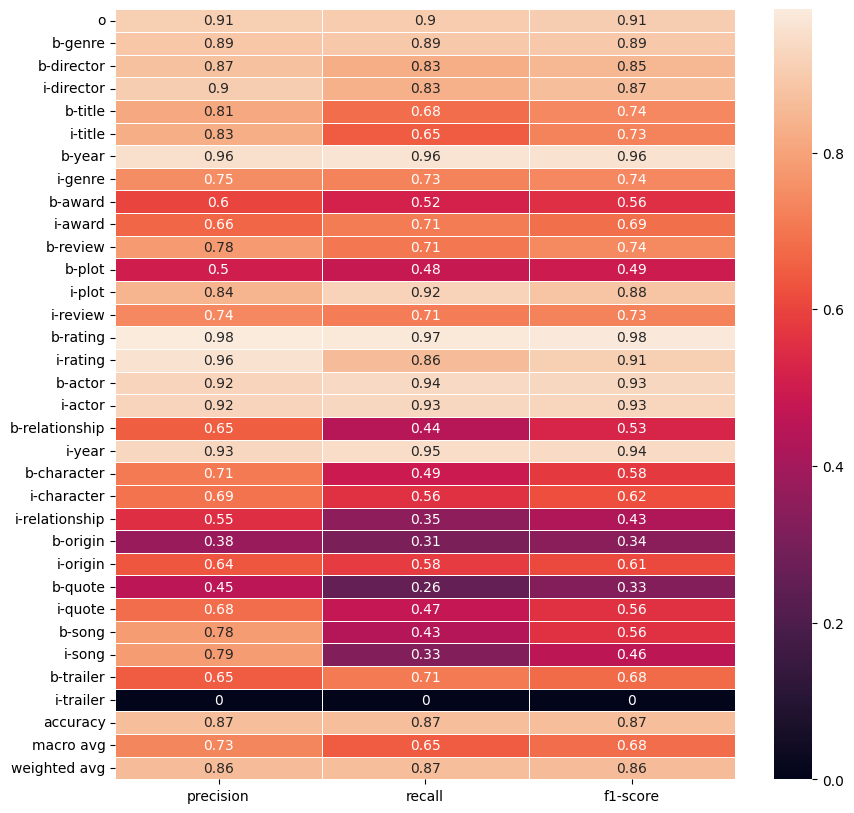

In [ ]:
# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)

# Word2Vec Features

In [ ]:
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
l_sents = [[tup[0] for tup in l_sent] for l_sent in l_sentences[0:]]

In [ ]:
l_sents[0]

['what', 'movies', 'star', 'bruce', 'willis']

In [ ]:
feature_size = 10
window_context = 30
min_word_count = 1
sample = 1e-3

In [ ]:
word2vec.Word2Vec()

In [ ]:
w2v_model = word2vec.Word2Vec(l_sents, 
                  vector_size= feature_size,
                  window = window_context,
                  min_count= min_word_count,
                  sample = sample,
                  )

In [ ]:
w2v_model.wv['what']

array([-0.74624395, -2.0799072 ,  2.7820344 ,  2.3366523 ,  0.8598433 ,
       -2.438018  ,  4.426962  ,  2.5536156 , -3.4388788 ,  0.58279073],
      dtype=float32)

In [ ]:
w2v_model.wv.get_normed_vectors()

array([[ 0.3485286 ,  0.19099167,  0.21500267, ...,  0.15718336,
        -0.6853779 , -0.02767766],
       [ 0.1644625 ,  0.12457786,  0.31098494, ...,  0.02415733,
        -0.58021986, -0.24330224],
       [ 0.1401228 ,  0.18386719,  0.26360768, ...,  0.08248157,
        -0.74818116, -0.04645745],
       ...,
       [-0.4139171 , -0.0938723 ,  0.22036943, ..., -0.31681028,
        -0.33627483,  0.2530463 ],
       [-0.18095791,  0.19722268, -0.04799867, ...,  0.28897056,
        -0.4697312 , -0.19120072],
       [ 0.20157555, -0.4232857 , -0.26113537, ..., -0.44267875,
        -0.03474994, -0.12938505]], dtype=float32)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
l_vectors = []

for word in w2v_model.wv.index_to_key:
    l_vectors.append(w2v_model.wv.get_vector(word))

In [ ]:
l_num_clus = []
l_silhouette_scores = []

for num_clus in [10, 20, 50, 100, 250, 500, 1000]:
    print(num_clus)
    kmeans = KMeans(n_clusters= num_clus)
    kmeans.fit_predict(l_vectors)
    l_num_clus.append(num_clus)
    l_silhouette_scores.append(silhouette_score(l_vectors, kmeans.labels_))

10
20
50
100
250
500
1000


In [ ]:
# create a word to cluster dictionary

# create a list to hold the words in the word2vec object
l_word_to_cluster = []
for word in w2v_model.wv.index_to_key:
    l_word_to_cluster.append(word)

dict_word_cluster = dict(zip(l_word_to_cluster,l_silhouette_scores))

In [ ]:
kmeans.

1000

In [ ]:
dict_word_cluster

{'the': 0.48699227,
 'a': 0.30858973,
 'movie': 0.099854395,
 'what': 0.07514213,
 'in': 0.0404902,
 'is': 0.03207697,
 'of': 0.031650122}

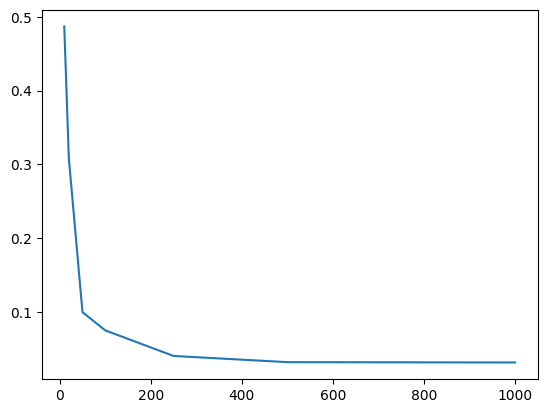

In [ ]:
import matplotlib.pyplot as plt
plt.plot(l_num_clus,l_silhouette_scores)

In [ ]:
w2v_model.wv.similarity('fire', 'star')

0.6647839

In [ ]:
def create_w2v_feature_dict (word2vec_model, word):
    dict_w2v = {}
    for sub_feat_num in range(len(word2vec_model.wv[word])):
        dict_w2v.update({'w2v_' + str(sub_feat_num): word2vec_model.wv[word][sub_feat_num]})
    return dict_w2v

In [ ]:
w2v_model.wv.most_similar('bruce')

[('morgan', 0.9906564354896545),
 ('beatty', 0.9891349673271179),
 ('freeman', 0.9868821501731873),
 ('weaver', 0.98685222864151),
 ('fisher', 0.9867677092552185),
 ('wrote', 0.9863390326499939),
 ('l', 0.9861729145050049),
 ('penn', 0.9826823472976685),
 ('statham', 0.9811477065086365),
 ('al', 0.9803164601325989)]

# Word2Vec: Create features in the data include W2V

In [ ]:
def word2features_w2v(l_sent: list, i, word2vec_model) -> dict:

    '''   Description:  Takes a sentence represented as a list of word tuples 
                        and an integer identifying the word tuple the function
                        will work on and returns a dictionary containing the 
                        words in each sentence and the corresponding features.
                        
                        l_sent: is formatted as a list of tuples where each 
                                 tuple is a:
                                   word in the sentence, 
                                   a part of speech tag,
                                   and an NER tag

                                   (word:str, POS:str, NER:str)
        
          Returns:      a dictionary, where each dictionary contains
                        features for one word in one sentence.
    
    '''
    word = l_sent[i][0]
    postag = l_sent[i][1]

    features = {'bias': 1.0,
                'word.lower()': word.lower(),
                'word[-3:]': word[-3:],
                'word[-2:]': word[-2:],
                'word.isupper': word.isupper(),
                'word.istitle()': word.istitle(),
                'word.isdigit()': word.isdigit(),
                'postag': postag,
                'postag[:2]': postag[:2],
               }
    
    features.update( create_w2v_feature_dict(w2v_model, word) )

    if i > 0:
        word1 = l_sent[i - 1][0]
        postag1 = l_sent[i - 1][1]
        features.update( {'-1:word.lower()': word1.lower(),
                          '-1:word.istitle()': word1.istitle(),
                          '-1:word.isupper': word1.isupper(),
                          '-1:postag': postag1,
                          '-1:postag[:2]': postag1[:2]
                          }
                        )
    
    else:
        features['BOS'] = True

    if i < len(l_sent) - 1:
        word1 = l_sent[i + 1][0]
        postag1 = l_sent[i + 1][1]
        features.update({'+1:word.lower()': word1.lower(),
                         '+1:word.istitle()': word1.istitle(),
                         '+1:word.isupper': word1.isupper(),
                         '+1:postag': postag1,
                         '+1:postag[:2]': postag1[:2]
                         }
                        )
    else:
        features['EOS'] = True
    
    return features

In [ ]:
def sent2features_w2v(l_sent:list, word2vec_model ) -> list:
    '''   Description:  Takes a sentence as a list of word tuples and returns a
                        list of dictionaries. The list contains tuples of
                        sentences, where each tuple is broken up into a word in
                        the sentence, a part of speech tag, and an NER tag.  
                        
                        l_sents: is formatted as a list of tuples where each 
                                 tuple contains a word in the sentence, the 
                                 word's part of speech tag, and an NER tag:  
                                 (word:str, POS:str, NER:str)
        
          Returns:      list of dictionaries of word features
    
    '''

    return [ word2features_w2v(l_sent, i, word2vec_model) for i in range(len(l_sent))]

In [ ]:
def sent2labels(l_sent: list) -> list:
    '''   Description:  Takes a list of sentence word tuples and returns the ner 
                        label from each word tuple. 
                        
                        l_sents is formatted as a list of tuples where each 
                                 tuple contains a word in the sentence, the 
                                 word's part of speech tag, and an NER tag:  
                                 (word:str, POS:str, NER:str)

          Returns:      list of dictionaries of word features
    
    '''

    return [label for token, postag, label in l_sent]

In [ ]:
grouped_df = df_ex.groupby('Sentence #').apply(agg_func)

In [ ]:
grouped_df.head()

Sentence #
Sentence: 1        [(Thousands, NNS, O), (of, IN, O), (demonstrat...
Sentence: 10       [(Iranian, JJ, B-gpe), (officials, NNS, O), (s...
Sentence: 100      [(Helicopter, NN, O), (gunships, NNS, O), (Sat...
Sentence: 1000     [(They, PRP, O), (left, VBD, O), (after, IN, O...
Sentence: 10000    [(U.N., NNP, B-geo), (relief, NN, O), (coordin...
dtype: object

In [ ]:
type(grouped_df1)

pandas.core.series.Series

In [ ]:
#grouped_df is a series NOT a dataframe
#each entry in the series is a list
# the elements in the list are tuples, 
#        - first entry is a sentence word
#        - second entry is a POS tag
#        - third entry is a IOB tag
grouped_df1[1]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [ ]:
# Standard tokenized sentence with POS and NER tags
# list of lists of tuples, where the list contains sentences reprsented as lists.
# Each sentence list contains a word in the sentence along with the POS and NER
l_sentences = [s for s in grouped_df1]
l_sentences[0]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [ ]:
word2features_w2v(l_sentences[0], 0, w2v_model)

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'w2v_0': -0.74624395,
 'w2v_1': -2.0799072,
 'w2v_2': 2.7820344,
 'w2v_3': 2.3366523,
 'w2v_4': 0.8598433,
 'w2v_5': -2.438018,
 'w2v_6': 4.426962,
 'w2v_7': 2.5536156,
 'w2v_8': -3.4388788,
 'w2v_9': 0.58279073,
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [ ]:
# make the feature set
X = np.array([sent2features_w2v(s, w2v_model) for s in l_sentences], dtype=object)
# make the label set
y = np.array([sent2labels(s) for s in l_sentences], dtype=object)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape

((16490,), (5497,))

In [ ]:
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1= 0.1, c2= 0.1, max_iterations= 100, all_possible_transitions= True, verbose= True)
crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|██████████| 16490/16490 [00:06<00:00, 2700.08it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 91509
Seconds required: 1.470

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=2.43  loss=533969.86 active=90028 feature_norm=1.00
Iter 2   time=1.22  loss=479375.01 active=87609 feature_norm=1.26
Iter 3   time=1.21  loss=453219.31 active=89020 feature_norm=1.58
Iter 4   time=1.20  loss=399874.22 active=88451 feature_norm=2.30
Iter 5   time=2.43  loss=384878.89 active=90303 feature_norm=2.98
Iter 6   time=1.61  loss=348582.20 active=90506 feature_norm=3.13
Iter 7   time=2.06  loss=335806.67 active=90569 feature_norm=3.63
Iter 8   time=1.28  loss=318625.75 active=90710 feature_norm=3.81
Iter 9   time=1.22  loss=305087.56 active=90630 feature_norm=4.28
Iter 

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100, verbose=True)

In [ ]:
joblib.dump(crf, 'crf_ner_movie_model.pkl')

['crf_ner_movie_model.pkl']

In [ ]:
y_pred = crf.predict(X_test)

In [ ]:
labels = crf.classes_
labels

['o',
 'b-genre',
 'b-director',
 'i-director',
 'b-title',
 'i-title',
 'b-year',
 'i-genre',
 'b-award',
 'i-award',
 'b-review',
 'b-plot',
 'i-plot',
 'i-review',
 'b-rating',
 'i-rating',
 'b-actor',
 'i-actor',
 'b-relationship',
 'i-year',
 'b-character',
 'i-character',
 'i-relationship',
 'b-origin',
 'i-origin',
 'b-quote',
 'i-quote',
 'b-song',
 'i-song',
 'b-trailer',
 'i-trailer']

In [ ]:
if 'o-outside' in labels:
    labels.remove('o-outside')
str_class_report = (crf_metrics.flat_classification_report(y_test,y_pred, labels=labels))
print(str_class_report)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-genre', 'b-director', 'i-director', 'b-title', 'i-title', 'b-year', 'i-genre', 'b-award', 'i-award', 'b-review', 'b-plot', 'i-plot', 'i-review', 'b-rating', 'i-rating', 'b-actor', 'i-actor', 'b-relationship', 'i-year', 'b-character', 'i-character', 'i-relationship', 'b-origin', 'i-origin', 'b-quote', 'i-quote', 'b-song', 'i-song', 'b-trailer', 'i-trailer'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


                precision    recall  f1-score   support

             o       0.91      0.90      0.91     36962
       b-genre       0.89      0.89      0.89      2416
    b-director       0.86      0.84      0.85      1076
    i-director       0.89      0.85      0.87      1096
       b-title       0.79      0.72      0.75       735
       i-title       0.77      0.68      0.73      1082
        b-year       0.96      0.96      0.96      1722
       i-genre       0.76      0.73      0.74       876
       b-award       0.59      0.52      0.55       110
       i-award       0.69      0.74      0.71       267
      b-review       0.77      0.71      0.74       935
        b-plot       0.50      0.48      0.49      2565
        i-plot       0.84      0.92      0.88     19162
      i-review       0.72      0.72      0.72       725
      b-rating       0.98      0.97      0.98       647
      i-rating       0.95      0.87      0.91       278
       b-actor       0.92      0.94      0.93  

In [ ]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

In [ ]:
df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

,precision,recall,f1-score,support
o,0.914241,0.896407,0.905236,36962.0
b-genre,0.891970,0.891970,0.891970,2416.0
b-director,0.860266,0.841078,0.850564,1076.0
i-director,0.886342,0.846715,0.866076,1096.0
b-title,0.794872,0.717007,0.753934,735.0


<Axes: >

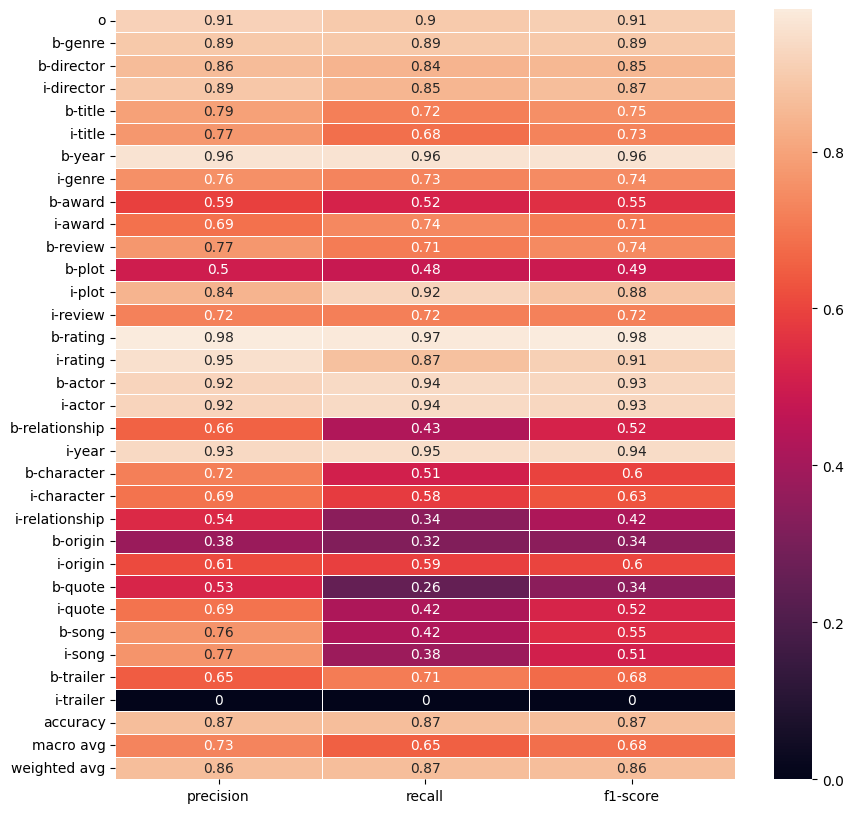

In [ ]:
# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)